In [1]:
%pip install numpy scipy matplotlib wfdb tqdm


Note: you may need to restart the kernel to use updated packages.


AUGMENTATION BASED FILTERING

In [2]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from tqdm import tqdm


In [3]:
DATASET_PATH = "../dataset"

print("Sample files:", os.listdir(DATASET_PATH)[:15])


Sample files: ['100.atr', '100.dat', '100.hea', '100.xws', '101.atr', '101.dat', '101.hea', '101.xws', '102-0.atr', '102.atr', '102.dat', '102.hea', '102.xws', '103.atr', '103.dat']


In [ ]:
#to avoid .xws
records = sorted(list(set(
    f.replace(".dat", "")
    for f in os.listdir(DATASET_PATH)
    if f.endswith(".dat")
)))

print("Total MIT-BIH records found:", len(records))
print("First 10 records:", records[:10])


Total MIT-BIH records found: 48
First 10 records: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109']


In [ ]:
def normalize_signal(signal):
    signal = signal - np.min(signal) #make min value as 0 (all poditive values)
    signal = signal / (np.max(signal) + 1e-8) #bring in range [0,1] and avoid division by 0
    return signal


def fix_length(signal, target_len=300): #Removes extra samples from the end
    if len(signal) > target_len:
        return signal[:target_len]
    else:
        return np.pad(signal, (0, target_len - len(signal)))


In [ ]:
#tachycardia >100bpm
def squeeze_signal(signal, factor=0.8): #heartbeat appears faster
    return resample(signal, int(len(signal) * factor))

#bradycardia <60 bpm
def stretch_signal(signal, factor=1.2): #heartbeat appears slower
    return resample(signal, int(len(signal) * factor))

#Simulates: Stronger electrical activity,Different electrode placement
def amplify_signal(signal, factor=1.2): 
    return np.clip(signal * factor, 0, 1)

#Mild tachycardia 100 - 120 bpm
def shrink_signal(signal, time_factor=0.9, amp_factor=0.8):
    shrunk = signal * amp_factor
    return resample(shrunk, int(len(shrunk) * time_factor))

In [7]:
def augment_beat(beat, target_len=300):
    beat = normalize_signal(beat)

    augmented = [
        fix_length(beat, target_len),
        fix_length(squeeze_signal(beat), target_len),
        fix_length(stretch_signal(beat), target_len),
        fix_length(amplify_signal(beat), target_len),
        fix_length(shrink_signal(beat), target_len)
    ]

    return augmented


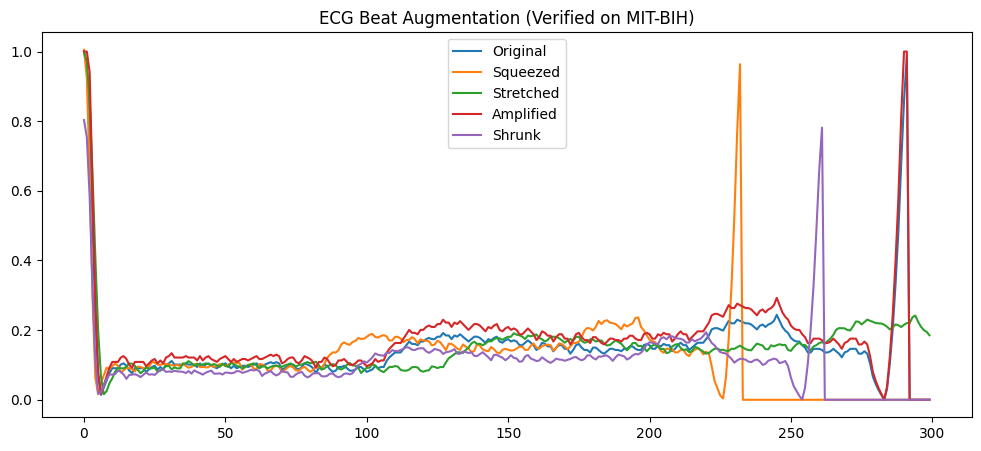

In [ ]:
record_id = "100"

record = wfdb.rdrecord(os.path.join(DATASET_PATH, record_id))
ann = wfdb.rdann(os.path.join(DATASET_PATH, record_id), 'atr')

signal = record.p_signal[:, 0] #first channel
r_peaks = ann.sample #R Peak detection

beat = signal[r_peaks[10]:r_peaks[11]] #beat segmentation
aug = augment_beat(beat)

plt.figure(figsize=(12, 5))
labels = ["Original", "Squeezed", "Stretched", "Amplified", "Shrunk"]

for s, l in zip(aug, labels):
    plt.plot(s, label=l)

plt.legend()
plt.title("ECG Beat Augmentation (Verified on MIT-BIH)")
plt.show()


In [ ]:
X, y = [], []

for rec in tqdm(records):
    record = wfdb.rdrecord(os.path.join(DATASET_PATH, rec))
    ann = wfdb.rdann(os.path.join(DATASET_PATH, rec), 'atr')

    signal = record.p_signal[:, 0]
    r_peaks = ann.sample #r peaks
    labels = ann.symbol

    for i in range(len(r_peaks) - 1):
        beat = signal[r_peaks[i]:r_peaks[i + 1]] #beat segmentation

        if len(beat) < 50:
            continue

        augmented_beats = augment_beat(beat)

        for b in augmented_beats:
            X.append(b)
            y.append(labels[i])


100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


In [ ]:
X = np.array(X) #augmented
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (562105, 300)
y shape: (562105,)


In [11]:
np.save("X_augmented.npy", X)
np.save("y_labels.npy", y)

print("Preprocessing complete. Files saved.")


Preprocessing complete. Files saved.


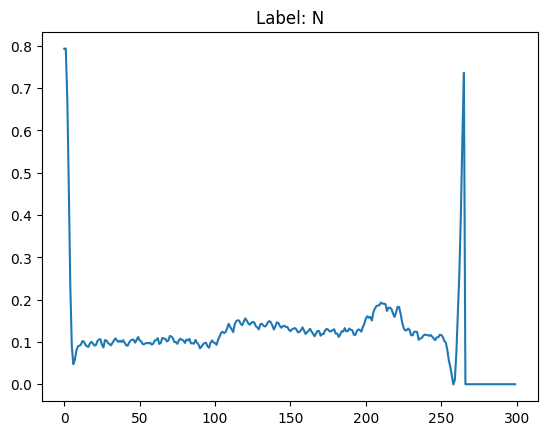

In [17]:
idx = 234
plt.plot(X[idx])
plt.title(f"Label: {y[idx]}")
plt.show()


AAMI (Association for the Advancement of Medical Instrumentation) Class Mapping

In [ ]:
import collections
collections.Counter(y)

Counter({'N': 374740,
         'L': 40355,
         'R': 36280,
         'V': 35640,
         '/': 35120,
         'A': 12710,
         '+': 6270,
         'f': 4910,
         'F': 4015,
         '~': 2865,
         '!': 2360,
         '"': 2185,
         'j': 1145,
         'x': 955,
         'a': 750,
         '|': 575,
         'E': 530,
         'J': 415,
         'Q': 160,
         'e': 80,
         ']': 25,
         '[': 10,
         'S': 10})

In [19]:
from collections import Counter

AAMI_MAP = {
    # Normal beats
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',

    # Supraventricular ectopic beats
    'A': 'S', 'a': 'S', 'J': 'S', 'S': 'S',

    # Ventricular ectopic beats
    'V': 'V', 'E': 'V',

    # Fusion beats
    'F': 'F', 'f': 'F',

    # Unknown / noise / paced
    'Q': 'Q', '/': 'Q', '~': 'Q', '|': 'Q'
}


In [20]:
X_aami = []
y_aami = []

for x, label in zip(X, y):
    if label in AAMI_MAP:          # keep only valid labels
        X_aami.append(x)
        y_aami.append(AAMI_MAP[label])

X_aami = np.array(X_aami)
y_aami = np.array(y_aami)


In [21]:
Counter(y_aami)


Counter({'N': 452600, 'Q': 38720, 'V': 36170, 'S': 13885, 'F': 8925})

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_aami)

print("Classes:", le.classes_)
print(y_encoded)


Classes: ['F' 'N' 'Q' 'S' 'V']
[1 1 1 ... 1 1 1]


CNN Reshape

In [24]:
X_cnn = X_aami.reshape(X_aami.shape[0], X_aami.shape[1], 1)

print("CNN input shape:", X_cnn.shape)
print("CNN labels shape:", y_encoded.shape)


CNN input shape: (550300, 300, 1)
CNN labels shape: (550300,)


 testing effectiveness of this pre processing pipeline
 ______________________________________________________


signal level effectiveness

a) Does preprocessing preserve ECG morphology? p-qrs-t visible

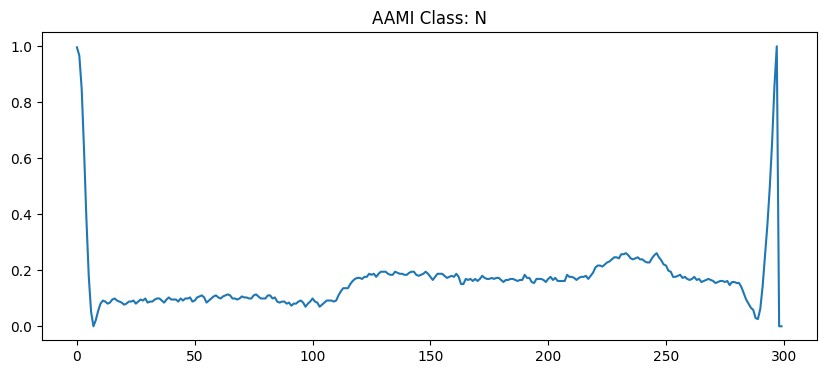

In [25]:
idx = 1000
plt.figure(figsize=(10,4))
plt.plot(X_cnn[idx].squeeze())
plt.title(f"AAMI Class: {le.inverse_transform([y_encoded[idx]])[0]}")
plt.show()


b) Shows lossless transformation?

In [30]:
orig = X_cnn[0].squeeze()
amp  = X_cnn[3].squeeze()   # amplified version of SAME beat

from scipy.stats import pearsonr
corr, _ = pearsonr(orig, amp)

print("Amplitude-only correlation:", corr)


Amplitude-only correlation: 0.9961011067432533


data level effectiveness

a) Dataset growth (proof of augmentation)

In [31]:
print("Total samples after augmentation:", X_cnn.shape[0])


Total samples after augmentation: 550300


b) variance increase

In [32]:
orig_var = np.var(X_cnn[::5], axis=1).mean()   # originals only
aug_var  = np.var(X_cnn, axis=1).mean()

print("Original variance:", orig_var)
print("Augmented variance:", aug_var)


Original variance: 0.027478794189203487
Augmented variance: 0.027945647120713457
